# Implementation of DeepBind neural network using EUGENe

**Authorship:**
Hayden Stites, Adam Klie, *08/12/2022*
***
**Description:**
Replicating experimental results from DeepBind and RNAcomplete (Ray, D., Kazan, H., Cook, K. et al.) using the eugene framework. 👍
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

import numpy as np
import pandas as pd
import eugene as eu

print(eu.__version__)

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: NVIDIA GeForce RTX 2070
janggu does not work on this machine, are you using MacOS or Linux?
janggu does not work on this machine, are you using MacOS or Linux?
0.1.0


# Dataloading
The RNAcomplete dataset has its own helper function in the `datasets` module that returns a `SeqData` object from the dataset. The function will download and load the normalized RNAcomplete dataset from the hugheslab online repository, but the raw version can be specified. The directory that the dataset is downloaded into is specified by `eu.settings.dataset_dir`.

In [2]:
# Import the RNAcomplete dataset
from eugene.datasets import RNAcomplete
sdata = RNAcomplete()

Dataset RNAcomplete norm_data.txt.gz has already been dowloaded.


In [9]:
# This displays the probe intensities recorded in the dataset
sdata.seqs_annot

,RNCMPT00100,RNCMPT00101,RNCMPT00102,RNCMPT00103,RNCMPT00104,RNCMPT00105,RNCMPT00106,RNCMPT00107,RNCMPT00108,RNCMPT00109,...,RNCMPT00008,RNCMPT00090,RNCMPT00091,RNCMPT00093,RNCMPT00094,RNCMPT00095,RNCMPT00096,RNCMPT00097,RNCMPT00099,RNCMPT00009
seq000000,1.122218,1.272641,-1.089717,-0.067146,0.831671,-0.070631,2.779642,2.509418,1.811186,2.762714,...,5.734185,0.907487,1.282393,0.861743,-0.115417,0.126413,1.010198,-0.123415,-0.060651,-0.398931
seq000001,8.840295,-2.113002,2.397376,-1.809082,-0.963712,-0.202229,-0.121975,-0.038112,-0.636935,-1.100769,...,NaN,0.029810,0.986617,3.979510,-0.388808,-0.348266,0.216500,-1.098411,3.820988,NaN
seq000002,-0.353194,-0.183539,-0.467021,-1.865032,0.663077,0.626212,0.910989,1.431777,0.003613,-0.086335,...,0.198792,1.821554,1.289043,-1.282063,-0.640817,0.054688,-1.351889,0.470123,-0.057985,-1.057710
seq000003,1.386679,-0.236797,-0.031135,-0.997679,-0.079547,0.473447,6.296981,7.877085,13.880688,10.165925,...,NaN,1.121754,1.009484,0.450070,-1.106999,1.617407,0.272935,0.621780,0.643033,NaN
seq000004,-0.267395,1.387100,0.986554,-0.622790,-0.261790,-0.782576,-0.674672,-0.432181,0.007804,-0.629471,...,NaN,0.472460,0.476233,-0.150370,-0.545728,-0.398383,-0.677650,-0.122340,-0.891034,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seq241352,1.674055,20.389858,0.770055,12.959504,11.324906,0.086366,7.169778,5.404982,1.465122,1.487886,...,0.687683,-1.841742,-0.141082,7.559083,0.501589,2.483238,-0.078747,1.047783,0.134119,1.433700
seq241353,-0.426269,-0.821294,0.591560,0.627169,0.459313,2.148826,-0.224518,-0.138735,-0.092908,-0.507217,...,NaN,1.903628,0.193573,0.087378,-0.699687,-2.233314,0.752704,-0.246153,-1.003296,NaN
seq241354,0.604869,-0.592981,-0.319087,-0.203019,0.625912,0.138792,0.195578,-0.531915,0.000103,0.128531,...,0.558631,-1.288070,0.400266,0.748016,0.156894,-0.426744,0.388496,0.169070,0.397499,NaN
seq241355,3.972188,1.513030,-1.339399,0.297040,-0.954315,1.459436,-0.456848,-0.532908,-1.082723,-0.884932,...,NaN,-0.019835,-1.293031,2.349549,2.965371,1.019436,-0.226711,18.726991,17.560194,NaN


# Data Visualization
In order to visualize the downloaded data, the `plotting` module can be used. This module has many functions that integrate `seaborn` functions with the `SeqData` object.

- The first plot depicts the frequency of a differing length of sequences appearing in the dataset.
- The second plot depicts the distribution of probe intensities in the `RNCMPT00100` column of the dataset. It can be noted that a few outliers are present in this graph, which would disrupt the machine learning process. This issue will be remedied with the `preprocessing` module.

In [ ]:
sdata["SEQ_LEN"] = [len(seq) for seq in sdata.seqs]
eu.pl.histplot(
    sdata, 
    keys="SEQ_LEN", 
    orient="h"
)

sdata["VIEW_TARGET"] = sdata["RNCMPT00100"].astype(float)
eu.pl.violinplot(
    sdata, 
    keys="VIEW_TARGET"
)

sdata.seqs_annot = sdata.seqs_annot.drop(["SEQ_LEN", "VIEW_TARGET"], axis=1)

# Preprocessing
The `preprocessing` module contains a myriad of functions that help `SeqData` objects once they are filled with data. After generating the reverse compliments, one hot encoding, and splitting the data, three additional transforms are performed on the data in order to increase the learning potential of the model.

- The values of probe intensities are clamped at 99.95% percentile per binding protein to eliminate outliers and balance the data.
- The probe intensities are normalized to a mean of 0 and a standard deviation of 1.
- Targets with too many NaN values are dropped, and the remaining ones have NaN values replaced with 0.

By `plotting` the distribution of probe intensities of the now preprocessed set of data, it can be seen how many of the outliers have been made less impactful on the set itself.

In [3]:
eu.pp.reverse_complement_data(sdata, alphabet="RNA")
eu.pp.one_hot_encode_data(sdata, alphabet="RNA", seq_align="center", fill_value=0.25)
eu.pp.train_test_split_data(sdata, split=0.8)

Reverse complementing sequences:   0%|          | 0/241357 [00:00<?, ?it/s]

SeqData object modified:
	rev_seqs: None -> 241357 rev_seqs added


One-hot-encoding sequences:   0%|          | 0/241357 [00:00<?, ?it/s]

One-hot-encoding sequences:   0%|          | 0/241357 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 241357 ohe_seqs added
	ohe_rev_seqs: None -> 241357 ohe_rev_seqs added
SeqData object modified:
    seqs_annot:
        + train


In [5]:
# Only process columns of usable data
target_list = sdata.seqs_annot.columns.drop("train").tolist()

In [6]:
eu.pp.clamp_percentiles(sdata, 0.9995, target_list)
eu.pp.scale_targets(sdata, target_list, "train", suffix=False)

In [7]:
eu.pp.clean_nan_data(sdata, target_list, nan_threshold=0.2)

SeqData object modified:
    seqs_annot:
        - RNCMPT00060, RNCMPT00015, RNCMPT00009, RNCMPT00129, RNCMPT00058, RNCMPT00144, RNCMPT00145, RNCMPT00008


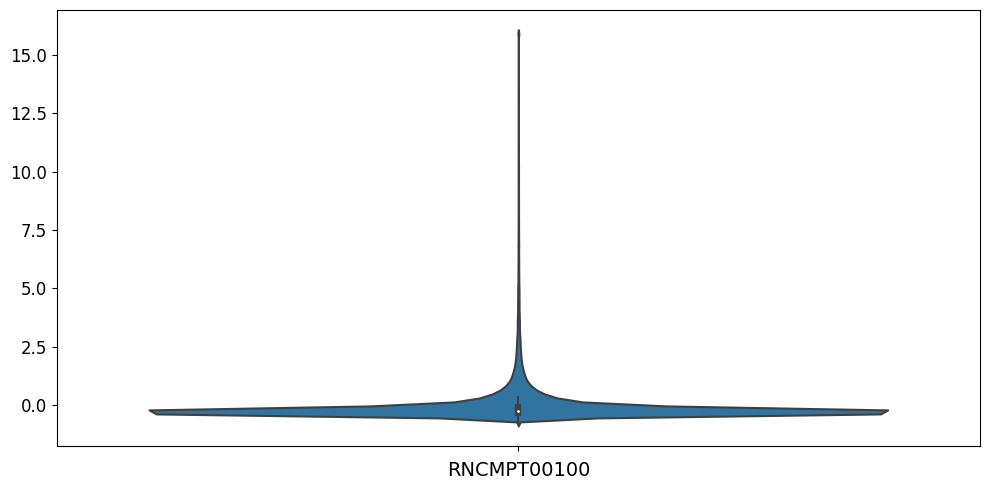

In [9]:
eu.pl.violinplot(
    sdata, 
    keys="RNCMPT00100"
)

The `eu.dl.write_h5sd` function allows a `SeqData` object (complete with all its data) to be written to an `h5sd` file. This can be used to configure and test a model multiple times without rerunning the `dataloading` and `preprocessing`.

In [8]:
eu.dl.write_h5sd(sdata, "SD_RNAcomplete.h5")

# Training

The `training` step is where the optimization of the model occurs. The `models` module comes with many preset models that can be accessed by calling one of their classes. For this analysis, the `DeepBind` model is used. All `models` can be instantiated with different parameters to modify their behavior. Because the dataset has 236 different targets, that many output dimensions will be in the model to allow for multitasking.

In [9]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

import numpy as np
import pandas as pd
import eugene as eu

# Configure EUGENe 
print(eu.__version__)
eu.settings.dataset_dir = "./datasets/"
eu.settings.logging_dir = "./eugene_log/"
eu.settings.output_dir = "./eugene_output/"

# Test experimentally
eu.settings.dl_num_workers = 4
eu.settings.batch_size = 2048
eu.settings.dl_pin_memory_gpu_training = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.1.0


In [2]:
# Load preprocessed sdata
sdata = eu.dl.read_h5sd("SD_RNAcomplete.h5")

In [ ]:
# Adam:
# Get rid of stride_c before its done. I can't figure out how to automatically calculate out the fc inputs from different mp strides. Check that all the kwargs are according to the paper too.
# I increased some dims to help it out a bit but you can set them back if you need. Double check that a motif length of 16 is conv_kernels (conv kernel size) and not mp kernel_size.

In [10]:
from eugene.models import DeepBind

conv_dropout = 0.25
fc_dropout = 0.25
batchnorm = True
model = DeepBind(
    input_len=41, # Length of padded sequences
    output_dim=236, # Number of multitask outputs
    strand="ds",
    task="regression",
    stride_c=4980,
    conv_kwargs=dict(channels=[4, 64], conv_kernels=[16], dropout_rates=conv_dropout, batchnorm=batchnorm),
    mp_kwargs=dict(kernel_size=4, stride=1),
    fc_kwargs=dict(hidden_dims=[1024, 512], dropout_rate=fc_dropout, batchnorm=batchnorm),
    lr=.0005,
    scheduler="reduce_lr_on_plateau",
    scheduler_patience=3
)

model.summary()
model

Model: DeepBind
Input length: 41
Output dimension: 236
Strand: ds
Task: regression
Aggregation: None
Loss function: mse_loss
Optimizer: adam
	Optimizer parameters: {}
Learning rate: 0.0005
Scheduler: reduce_lr_on_plateau
Scheduler patience: 3


DeepBind(
  (hp_metric): R2Score()
  (max_pool): MaxPool1d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool1d(kernel_size=(4,), stride=(1,), padding=(0,))
  (convnet): BasicConv1D(
    (module): Sequential(
      (0): Conv1d(4, 64, kernel_size=(16,), stride=(1,))
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
      (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fcn): BasicFullyConnectedModule(
    (module): Sequential(
      (0): Linear(in_features=6644, out_features=1024, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.25, inplace=False)
      (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): ReLU()
      (6): Dropout(p=0.25, inplace=False)
      (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Linear(in_features=512, out_

In [11]:
target_list = sdata.seqs_annot.columns.drop("train").tolist()
eu.train.fit(
    model=model,
    sdata=sdata,
    gpus=1,
    target=target_list,
    train_key="train",
    epochs=30
)

No transforms given, assuming just need to tensorize).


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).



  | Name      | Type                      | Params
--------------------------------------------------------
0 | hp_metric | R2Score                   | 0     
1 | max_pool  | MaxPool1d                 | 0     
2 | avg_pool  | AvgPool1d                 | 0     
3 | convnet   | BasicConv1D               | 4.3 K 
4 | fcn       | BasicFullyConnectedModule | 7.5 M 
--------------------------------------------------------
7.5 M     Trainable params
0         Non-trainable params
7.5 M     Total params
29.831    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 13


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.804


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 0.748


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.713


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.691


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.679


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.671


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.662


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.658


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.650


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.632


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.629


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.627


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.626


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.626


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.624


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.623


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.623


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.622


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.621


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.620


Validating: 0it [00:00, ?it/s]

# Evaluation
Evaluation allows users to see how well their models perform by making `predictions` and `plotting` the predicted vs. actual data.

- First, the best performing model from training is loaded in.
- Predictions are made using the `train_val_predictions` function, which outputs a table of predictions for both sets of data.
- The data is then plotted to allow its performance to be visually inspected.

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

import numpy as np
import pandas as pd
import eugene as eu

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: NVIDIA GeForce RTX 2070
janggu does not work on this machine, are you using MacOS or Linux?
janggu does not work on this machine, are you using MacOS or Linux?


In [2]:
# Load preprocessed sdata
sdata = eu.dl.read_h5sd("SD_RNAcomplete.h5")

In [3]:
model = eu.models.DeepBind.load_from_checkpoint("eugene_log/dsDeepBind_regression/version_1/checkpoints/epoch=28-step=2754.ckpt")

In [4]:
target_list = sdata.seqs_annot.columns.drop("train").tolist()

In [ ]:
eu.predict.train_val_predictions(
    model,
    sdata=sdata,
    target=target_list,
    train_key="train"
)

In [ ]:
train_idx = np.where(sdata.seqs_annot["train"] == True)[0]
prediction_target_list = [i + "_predictions" for i in target_list]
eu.pl.performance_scatter(
    sdata, 
    seq_idx=train_idx, 
    targets=target_list[0], 
    predictions=prediction_target_list[0],
    title="Training Set Performance",
    alpha=0.5,
)

# Interpretation
Potentially the most important step in the EUGENe workflow is the interpretation of the model's predictions. This is done through the `interpret` module. All the functions in this module act on either `SeqData` and Models or just Models. Results from these calls can be visualized using the `plotting` module.
---
There are many options for interpreting the model's predictions, and we will again point users to the API for all the options and their arguments. We list examples for a few common ones below.


```python
eu.interpret.generate_pfms(
    best_model_leaf, 
    sdata_leaf_test
)
```

## Feature attribution
We can calculate the contribution of each nucleotide to the model's predictions for a sequence by using the `interpret` module's `feature_attribution` function. We currently implement several different methods for this, includeing `DeepLift, ISM, InputXGradient and DeepSHAP`.
```python
eu.interpret.feature_attribution(
    best_model,
    sdata_test,
    saliency_method="DeepLift",
    device= "cuda" if eu.settings.gpus > 0 else "cpu"
)
```

In [5]:
eu.interpret.generate_pfms(
    model,
    sdata,
    device="cpu"
)

No transforms given, assuming just need to tensorize).


Getting maximial activating seqlets:   0%|          | 0/1885 [00:00<?, ?it/s]

Getting PFMs from filters:   0%|          | 0/64 [00:00<?, ?it/s]

In [19]:
sdata.uns["pfms"][0]

,A,C,G,T
0,6490.0,4988.0,9176.0,4201.0
1,5057.0,5865.0,6517.0,7416.0
2,4209.0,6770.0,11394.0,2482.0
3,4403.0,6432.0,3800.0,10220.0
4,3564.0,9965.0,9149.0,2177.0
5,3909.0,6434.0,1325.0,13187.0
6,3777.0,6959.0,11760.0,2359.0
7,5468.0,5673.0,336.0,13378.0
8,5771.0,3424.0,15186.0,474.0
9,4421.0,101.0,17.0,20316.0


## Filter Visualization 
We can get an idea for what each filter of first convoulional layer of the model is seeing by using the `interpret` module's `generate_pfms` function. This creates a position frequency matrix for each filter in the model using sequences that highly activate that filter (can be defined in multiple ways). We often times pass the the test sequences through the model, but you can theoretically pass any sequences you want.
```python
eu.interpret.generate_pfms(
    best_model, 
    sdata_test
)
```

In [ ]:
# TODO: Run filter visualization on your model

## Other intepretation methods
We currently implement a few other methods for interpreting the model's predictions. These include:
- Dimensionality Reduction on your importance scores: e.g. `eu.interpret.pca`
- ...
We are looking to add more! If you are interested in contributing...

In [ ]:
# TODO: Perform other intepretation methods on your trained model

# Wrapping up
EUGENe is very much meant to be a community project. It represents a collection of data, models, and techniques meant for analyzing sequence data with deep learning. We are looking for contributions in almost every aspect of EUGENe. We are particularly interested in:

- New model additions through the `models` module
- New dataset additions through the `datasets` module
- New preprocessing techniques through the `preprocessing` module
- New visualization techniques through the `plotting` module
- New interpretation techniques through the `interpret` module
- New methods for training models in the `train` module

Please do not hesitate to contact us if you have any questions or suggestions.

---